

# Source estimation with MNE (Incl. dSPM, sLORETA, eLORETA) and beamforming

This tutorial shows how to compute and apply linear
minimum-norm inverse methods and beamformers on evoked data.


In [1]:
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse, make_inverse_operator

We first compute ERPs/ERFs again:



Opening raw data file /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
 

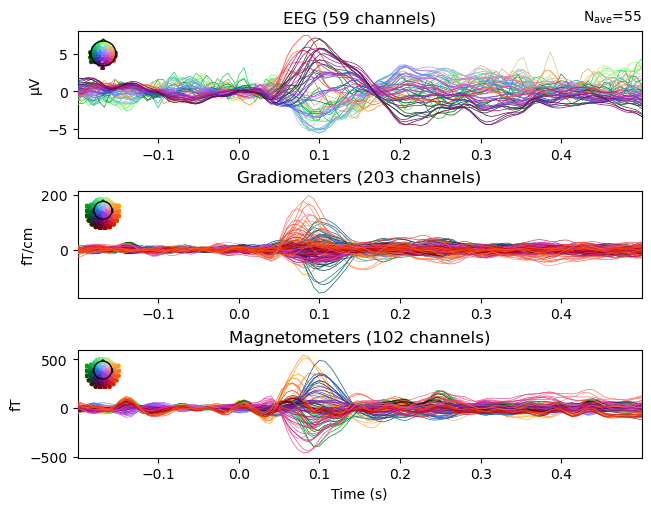

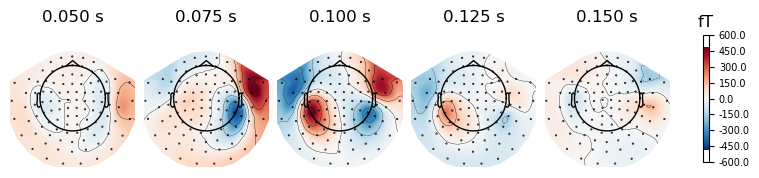

In [3]:
data_path = sample.data_path()
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
subjects_dir = data_path / "subjects"

raw = mne.io.read_raw_fif(raw_fname)  # already has an average reference
events = mne.find_events(raw, stim_channel="STI 014")

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info["bads"] = ["MEG 2443", "EEG 053"]
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=("meg", "eeg", "eog"),
    baseline=baseline,
    reject=reject,
)

evoked = epochs.average()
evoked.plot(time_unit="s")
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type="mag");

## Compute regularised noise covariance
We compute a regularised noise covariance matrix to suppress noise in our source estimates ("regularisation").

For more details see `tut-compute-covariance`.



Loading data for 72 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
17 bad epochs dropped


/tmp/ipykernel_18495/4013073653.py:3: RuntimeWarning: Too few samples (required : 1825 got : 1705), covariance estimate may be unreliable
  noise_cov = mne.compute_covariance(


    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 1705
log-likelihood on unseen data (descending order):
   shrunk: -1587.712
   empirical: -1846.748
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.98  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 203 dim * 3.5  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Us

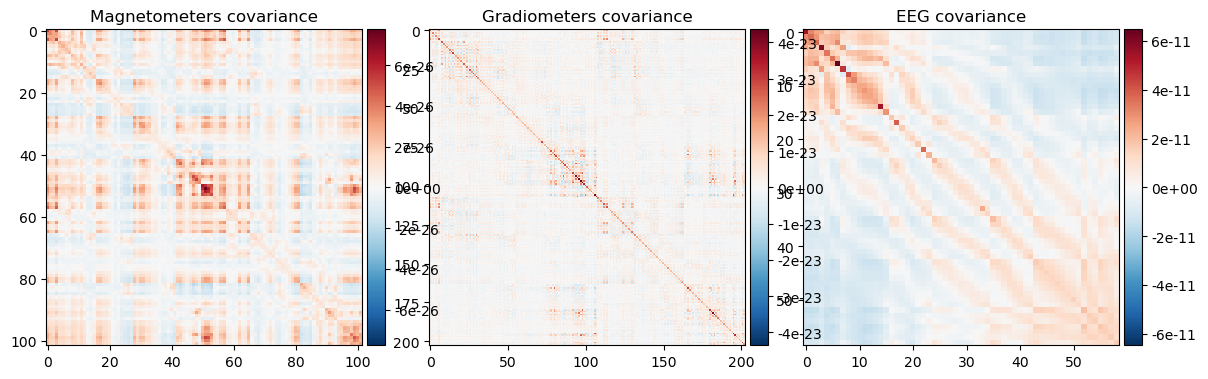

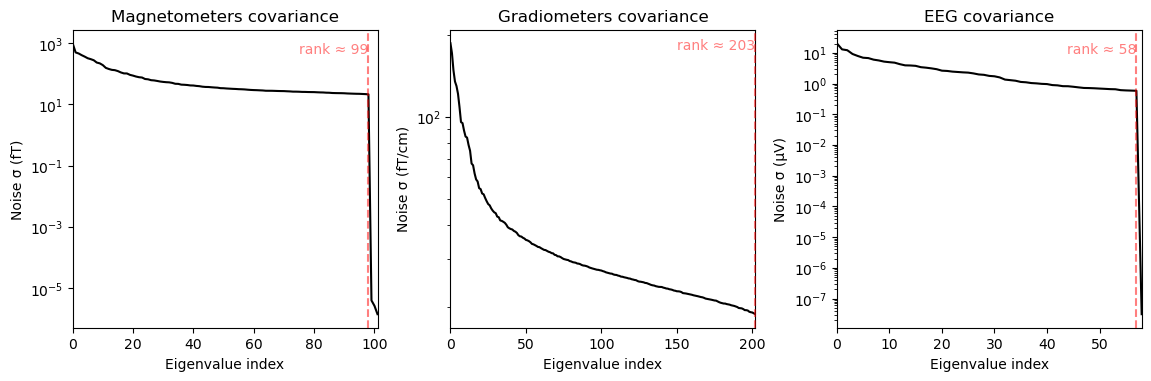

In [4]:
# only baseline interval is used for "noise" covariance matrix
# the best of two options will be picked
noise_cov = mne.compute_covariance(
    epochs, tmax=0.0, method=["shrunk", "empirical"], rank=None, verbose=True
)

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

Now we can look at "whitenened" data, i.e. data normalised by the inverse of the covariance matrix. This turns every channel type into signal-to-noise ratios, i.e. comparable units. It is also a pre-requisite to combine channel types in source estimation (and classification etc.).

We should check that our noise covariance matrix is appropriate for whitening our evoked data before source estimation.


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 5.5e-14 (2.2e-16 eps * 59 dim * 4.2  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 203 dim * 3.5  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.98  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 4)
Computing rank from covariance with rank={'eeg': 58, 'grad': 203, 'mag': 99, 'meg': 302}
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
    Cre

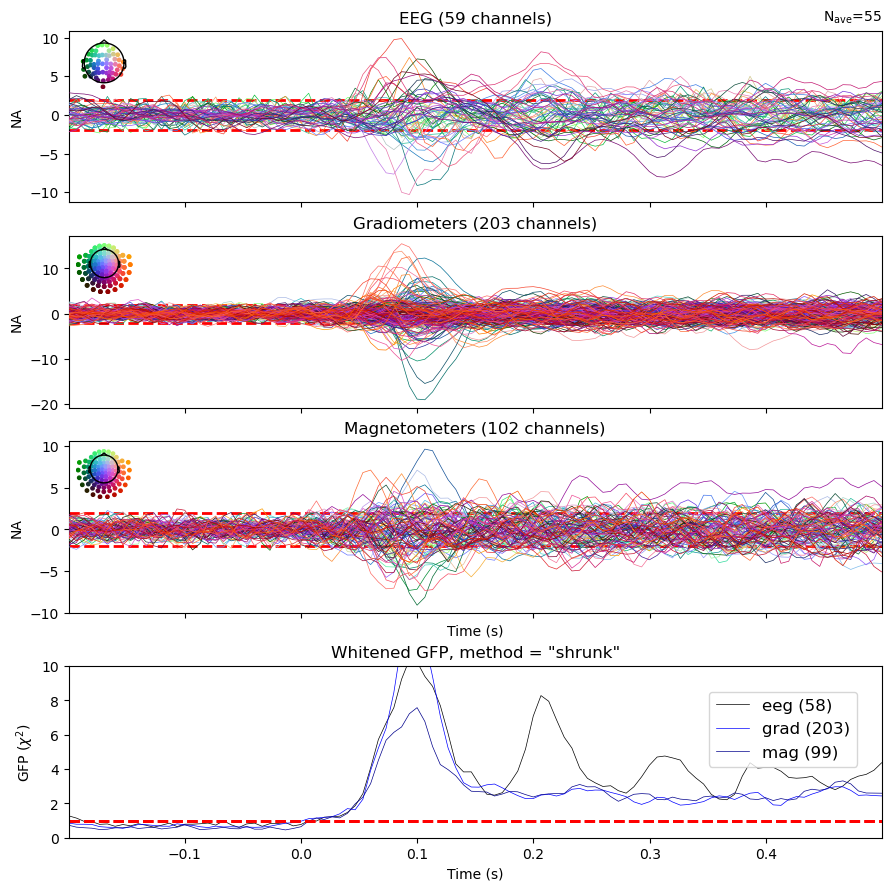

In [5]:
evoked.plot_white(noise_cov, time_unit="s");

## Inverse modeling: MNE/dSPM on evoked and raw data
We now have all the ingredients for source estimation:
* The data (here ERPs/ERFs).
* The forward solution (source space, head model, co-registration).
* The noise covariance matrix.

Here we now read the forward solution from a previous step. You will likely need to compute
one for your own data -- see `tut-forward` for information on how
to do it.



In [6]:
fname_fwd = data_path / "MEG" / "sample" / "sample_audvis-meg-oct-6-fwd.fif"
fwd = mne.read_forward_solution(fname_fwd)

Reading forward solution from /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


We are ready to put everything together to make an MEG inverse operator.

Note that we can choose parameters for source orientation ("loose") and depth weighting ("depth") here.



In [7]:
inverse_operator = make_inverse_operator(
    evoked.info, fwd, noise_cov, loose=0.2, depth=None
)
#  'loose=0.2': 80% of variance per dipole perpendicular/normal to cortical surface
#  'depth=None': no prior information about depth of sources included

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.
    305 out of 306 channels remain after picking
Selected 305 channels
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 2.9e-13 (2.2e-16 eps * 305 dim * 4.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular 

<div class="alert alert-info"><h4>Note</h4><p>You can write the inverse operator to disk with:

```
from mne.minimum_norm import write_inverse_operator
write_inverse_operator(
    "sample_audvis-meg-oct-6-inv.fif", inverse_operator
)</p></div>
```

## Compute inverse solution
We are ready to apply the inverse operator to our data and obtain source time
courses.


The inverse operator is independent of the data (apart from the covariance matrix, which reflects the noise whose structure should not change across conditions within the same session).

We can now apply the inverse operator to any data that are consistent with its sensor configuration (i.e. sensor locations and co-registration) and noise structure (i.e. covariance matrix). This is usually the case for data from within the same recording session.

In [8]:
method = "MNE"  # source estimation method
snr = 3.  # signal-to-noise ratio, regularisation
lambda2 = 1.0 / snr**2  # ...is translated into a regularisation parameter to suppress noise
stc, residual = apply_inverse(
    evoked,
    inverse_operator,
    lambda2,
    method=method,
    pick_ori=None,  # whether to return signed amplitudes, free orientations, or intensities
    return_residual=True,
    verbose=True,
)
# this returns a Source Time Course (STC) object, which contains source time courses for every vertex

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
Applying inverse operator to "aud_l"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  66.4% variance
    Combining the current components...
[done]


Let's briefly look at information about the SourceEstimate object ("Source Time Course").

We can access the source estimate data as a numpy array.

In [9]:
print(stc)
print(stc.data.shape)
print(stc.data.min(), stc.data.max())

<SourceEstimate | 7498 vertices, subject : sample, tmin : -199.79521315838787 (ms), tmax : 499.48803289596964 (ms), tstep : 6.659840438612929 (ms), data shape : (7498, 106), ~6.1 MiB>
(7498, 106)
1.0126176278907996e-14 7.957323919391392e-10


## Visualisation - Time Courses
Before we plot a fancy brain, we remind ourselves that we are dealing with spatio-temporal data, i.e. time courses per vertex.


[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'MNE value')]

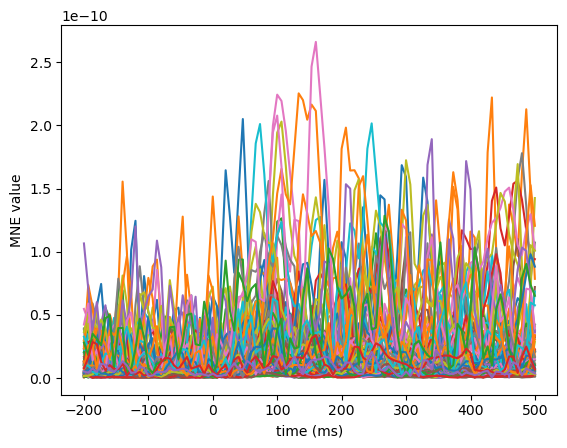

In [10]:
fig, ax = plt.subplots()
ax.plot(1e3 * stc.times, stc.data[::100, :].T)
ax.set(xlabel="time (ms)", ylabel="%s value" % method)

Examine the original data and the residual after fitting:



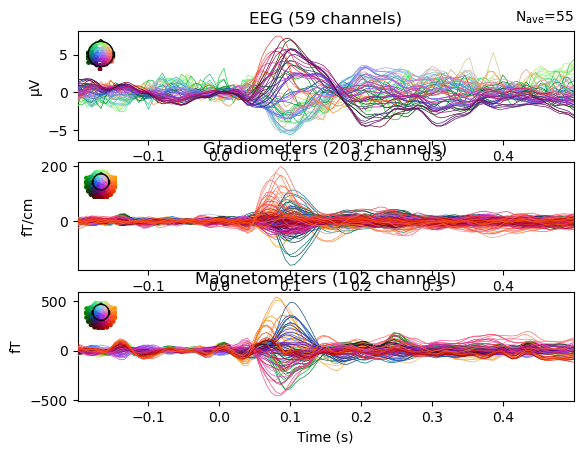

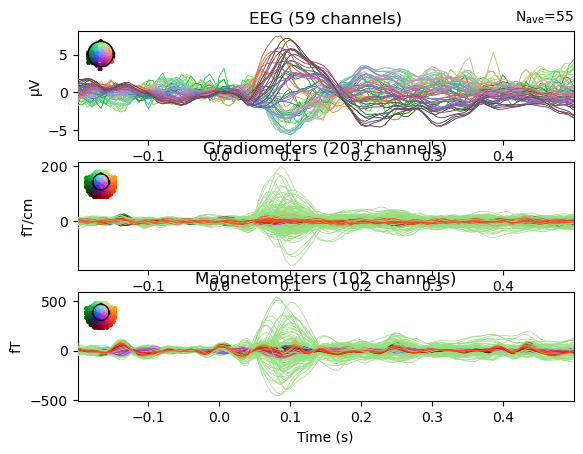

In [11]:
fig, axes = plt.subplots(3, 1)
evoked.plot(axes=axes);
for ax in axes:
    for text in list(ax.texts):
        text.remove()
    for line in ax.lines:
        line.set_color("#98df81")
residual.plot(axes=axes)

Note: It is not clear to me why the residual is higher for EEG than MEG.

## Visualisation - Spatial Distributions

Now we are ready to look at source estimates in their whole glory.

Here we use peak getter to move visualisation to the time point of the peak
and draw a marker at the maximum peak vertex.



In [12]:
vertno_max, time_max = stc.get_peak(hemi="rh")

# scale plots with respect to global maximum
maxamp = stc.data.max()
lims = (0, maxamp/2., maxamp)

subjects_dir = data_path / "subjects"
surfer_kwargs = dict(
    hemi="rh",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=lims),
    views="lateral",
    initial_time=time_max,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10,
)
brain = stc.plot(**surfer_kwargs)
brain.add_foci(
    vertno_max,
    coords_as_verts=True,
    hemi="rh",
    color="blue",
    scale_factor=0.6,
    alpha=0.5,
)
brain.add_text(
    0.1, 0.9, method + " (plus location of maximal activation)", "title", font_size=14
)

Using pyvistaqt 3d backend.
True


Note: the quickest way to visualise an STC object is to type 'stc.plot(subjects_dir=subjects_dir)', e.g. for a quick data check. You will then have to pick the right time points and adjust the scaling.

You can **save your results as a movie**. The documentation website's movie is generated with:
brain.save_movie(..., tmin=0.05, tmax=0.15, interpolation='linear', time_dilation=20, framerate=10, time_viewer=True)

There are many other ways to visualize and work with source data, see
for example:

- `tut-viz-stcs`
- `ex-morph-surface`
- `ex-morph-volume`
- `ex-vector-mne-solution`
- `tut-dipole-orientations`
- `tut-mne-fixed-free`
- `examples using apply_inverse
  <sphx_glr_backreferences_mne.minimum_norm.apply_inverse>`.



**Exercises:**
* explore visualisation parameters, e.g. plot both hemispheres (hint: look at the documentation for the 'plot' method).
* create, save, and watch a movie of source activations.
* use different source estimation methods (see 'method' parameter in 'apply_inverse()').
* look at different conditions (hint: average several conditions separately (see documentation of 'Epochs.average()', then specify different Evoked objects in 'apply_inverse()').
* create and apply inverse operators for EEG and MEG separately.

## Regularisation

Regularisation aims at avoiding overfitting a model to noisy data. Some part of your data is not produced by brain sources (but by sensor noise, movement, etc.), and therefore cannot be explained by our model (i.e. the forward solution, or leadfield). Thus, explaining 100% of our data is not desirable - some "brain" activity may appear just in order to explain noise in our data. These spurious sources can even be larger in amplitude than the estimates for true brain activity, and often manifests itself at high spatial frequencies.

Regularisation addresses this by spatially smoothing the source estimates, while sacrificing some explained variance. The question now is: How much variance do we sacrifice, and how much smoothing is appropriate? MNE proposes the heuristic choice to assume an amplitude signal-to-noise ratio of 3, i.e. a variance SNR of 9. This roughly corresponds to the assumption that about 10% or our data are noise. This SNR is then used to compure the regularisation parameter "lambda" as 1 / $SNR^{2}$.

Note that 'snr=3' is chosen for evoked data. For raw or single-trial data MNE recommends a value of 'snr=1', since these data will be noisier than averages.

There are more sophisticated ways to compute optimal regularisation parameters. However, they would have to be fitted for individual participants, conditions, and even time points (as SNR varies with all of these parameters), which may introduce different degrees of smoothing and therefore a confound for contrasts of interest (e.g. conditions). 

**Exercises:**
* Change the regularisation parameter above (via 'snr') and observe the changes in the source time courses and distributions.

## Beamforming

Beamformers also produce time courses and spatial distributions in source space, but they make different assumptions than the MNE-type methods above. <br>
They operate like "dipole scans" and work optimally for focal and temporally uncorrelated sources. <br>
They are often described as "spatial filters" that are optimally focussing on particular brain areas while suppressing activity from others - but this is also the case for the methods used above, depending on your criterion of "optimal".

Beamformers require two types of covariance matrix: one for the signal, i.e. a "data covariance matrix"; and one for the noise, i.e. a "noise covariance matrix" (as before).<br>
Note the different latency intervals used in the following commands. We will only plot the data covariance matrix, since we know the noise covariance matrix already.

Loading data for 55 events and 106 original time points ...
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using SHRUNK
Done.
Number of samples used : 2035
[done]
Loading data for 55 events and 106 original time points ...


/tmp/ipykernel_18495/2908060149.py:4: RuntimeWarning: Too few samples (required : 1825 got : 1705), covariance estimate may be unreliable
  noise_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=0, method="shrunk")


    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using SHRUNK
Done.
Number of samples used : 1705
[done]
Computing rank from covariance with rank=None
    Using tolerance 3.9e-14 (2.2e-16 eps * 102 dim * 1.7  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 4.2e-13 (2.2e-16 eps * 203 dim * 9.2  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 8.2e-14 (2.2e-16 eps * 59 dim * 6.3  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 0 projectors


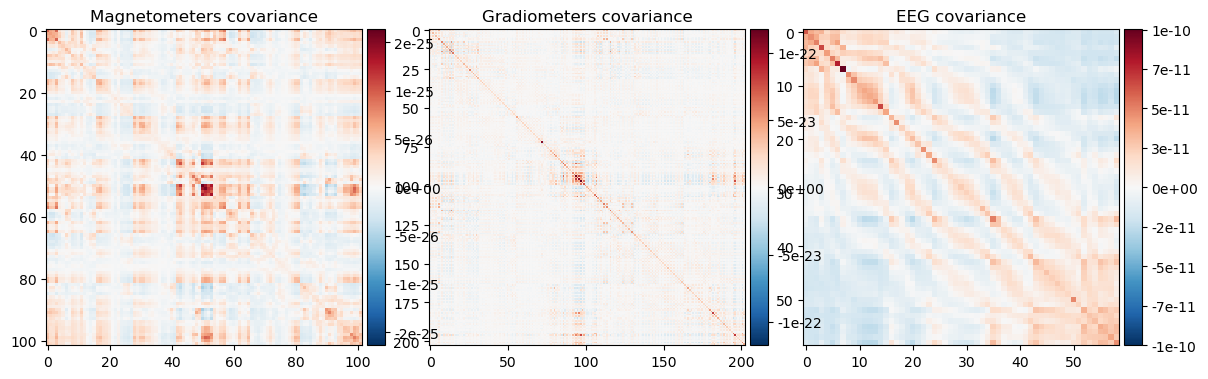

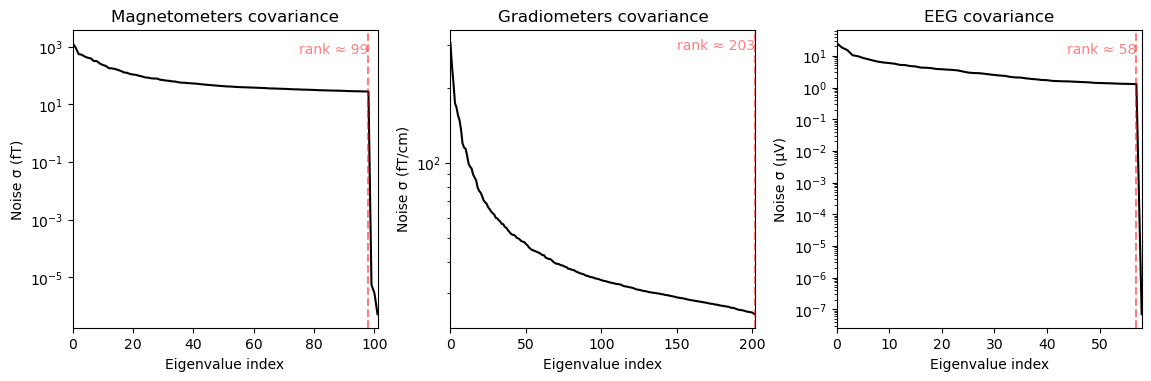

(<Figure size 1140x370 with 6 Axes>, <Figure size 1140x370 with 3 Axes>)

In [13]:
# Beamforming requires a "data" and a "noise" covariance matrix
# we know from previous examples that 'shrunk' is the best option for these data
data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=0.25, method="shrunk")
noise_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=0, method="shrunk")
data_cov.plot(epochs.info)

We can now create the "filters" for our beamformer. This is the analogue of the "inverse operator" for MNE-type methods from above, which can then be applied to any appropriate data. 

In [14]:
filters = mne.beamformer.make_lcmv(
    evoked.info,
    fwd,
    data_cov,
    reg=0.05,
    noise_cov=noise_cov,
    rank=None,
)

# You can save the filter for later use with:
# filters.save('filters-lcmv.h5')filters = make_lcmv(

Excluding 59 channel(s) missing from the provided forward operator and/or covariance matrices
Computing rank from covariance with rank=None
    Using tolerance 6.9e-13 (2.2e-16 eps * 305 dim * 10  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.9e-13 (2.2e-16 eps * 305 dim * 4.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
Making LCMV beamformer with rank {'meg': 302}
Computing inverse operator with 305 channels.
    305 out of 306 channels remain after picking
Selected 305 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank={'meg': 302}
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamfor

Now we apply the beamformer filters to evoked data (analogous to 'apply_inverse()' above.

In [15]:
# apply beamformer weights to real data
# note: the data should correspond to the data covariance matrix
stc_bf = mne.beamformer.apply_lcmv(evoked, filters)

combining the current components...


And we can admire the result:

In [16]:
vertno_max, time_max = stc_bf.get_peak(hemi="rh")

# scale plots with respect to global maximum
maxamp = np.abs(stc_bf.data).max()  # note: absolute value
lims = (0, maxamp/2., 2*maxamp)

subjects_dir = data_path / "subjects"
surfer_kwargs = dict(
    hemi="rh",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=lims),
    views="lateral",
    initial_time=time_max,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10,
)
brain_bf = stc_bf.plot(**surfer_kwargs)
brain_bf.add_foci(
    vertno_max,
    coords_as_verts=True,
    hemi="rh",
    color="blue",
    scale_factor=0.6,
    alpha=0.5,
)
brain_bf.add_text(
    0.1, 0.9, "LCMV beamformer (plus location of maximal activation)", "title", font_size=14
)

True


**Exercise:**
* You can repeat the exercises from the MNE section above.
* How does make_lcmv deal with source orientations? Check the option 'vector'.